<a href="https://colab.research.google.com/github/MelSaFer/Inteligencia-artificial/blob/main/Tarea_Corta_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Instituto Tecnológico de Costa Rica**

**IC6200 - Inteligencia artificial**

**Tarea Corta 1**

**Profesor**: Kenneth Roberto Obando Rodríguez

**Estudiantes**:

*   Mario Lara Molina - 2020035341
*   Melany Salas Fernández - 2021121147
*   Moisés Solano Espinoza

# **Desarrollo de la solución**

Enter population size (default 300): 300
Enter number of generations (default 40000): 5000
Enter mutation chance (default 0.2): 0.2
Enter percentage of individuals preserved (default 0.4): 0.4
Enter percentage of new individuals created (default 0.1): 0.2
Enter image URL (default is a plant): 


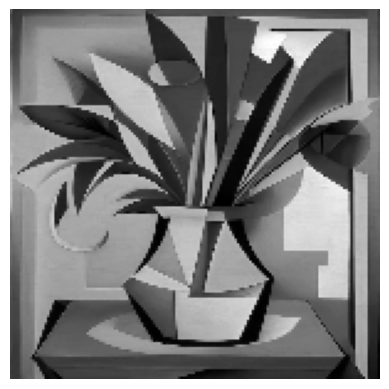

  0%|          | 0/5000 [00:00<?, ?it/s]

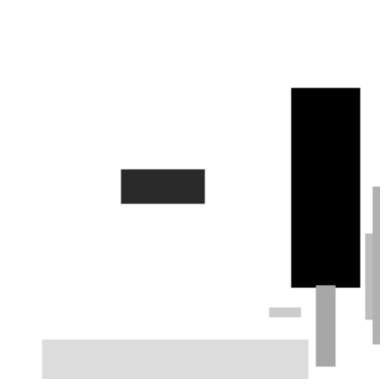

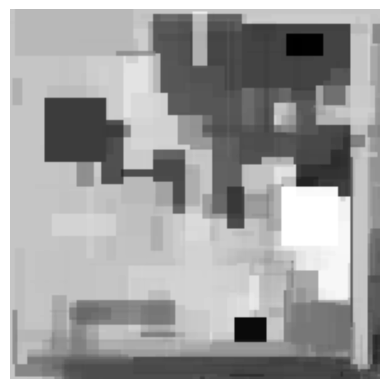

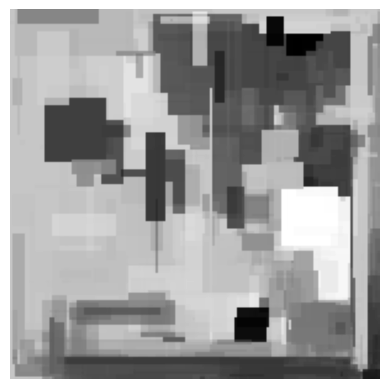

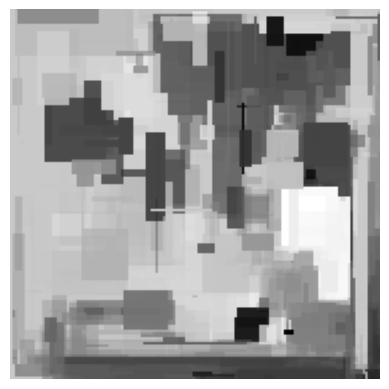

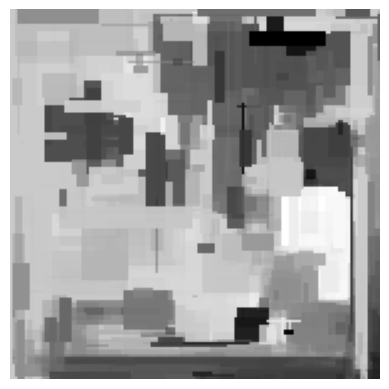

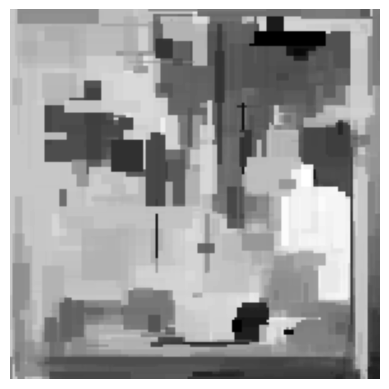

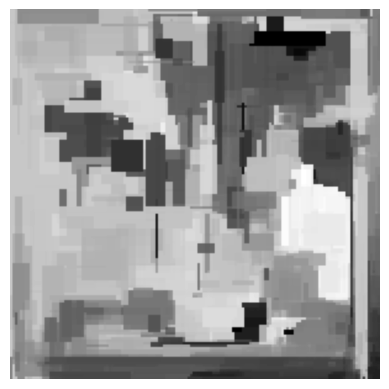

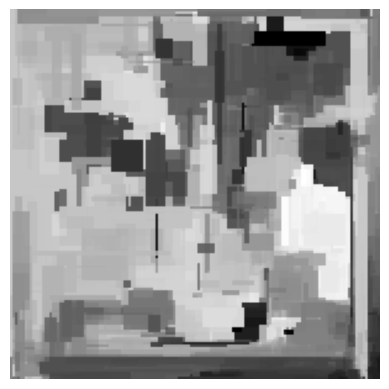

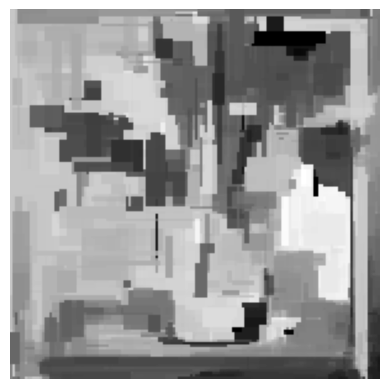

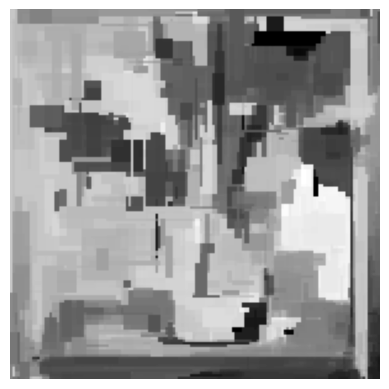

Final fitness: 52.62485428852881


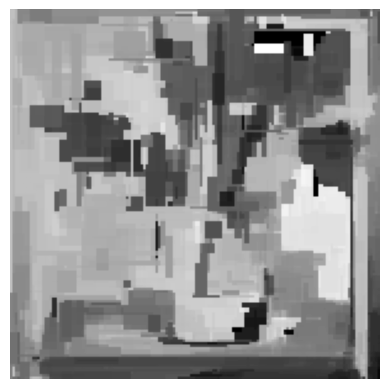

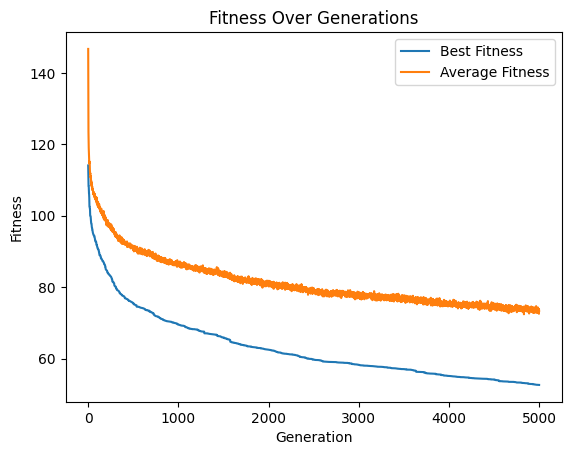

In [ ]:
import pandas as pd
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
from IPython.display import Image as IPImage, display
from PIL import Image, ImageDraw
import requests
from io import BytesIO
from tqdm.auto import tqdm

# Default variables
MUTATION_CHANCE = 0.2  # percentage probability that an individual will mutate
KEEP_PERCENTAGE = 0.4  # percentage of individuals preserved
NEW_INDIVIDUALS_PERCENTAGE = 0.1  # percentage of new individuals created
GIF_SCALE_FACTOR = 6  # scaling factor to make the GIF larger (50x50 -> 300x300)
POPULATION_SIZE = 300  # default number of individuals per population
NUM_GENERATIONS = 40000  # default maximum number of generations
IMAGE_SAVE_INTERVAL = 500  # save image every N generations
DEFAULT_IMAGE_URL = "https://img.freepik.com/fotos-premium/cubismo-inspirado-ramo-pintura-artistico-flores-obra-floral-arte-popular_688547-14028.jpg"  # Default image URL

class Individual:
    # Constructor
    def __init__(self, img_dimensions):
        self.img_dimensions = img_dimensions
        self.image = self.create_random_image()
        self.fitness = None

    """
    Method to generate a random gray scale color
    Entries: None
    Returns: A random gray scale color
    """
    def rand_color(self):
        return random.randint(0, 255)

    """
    Method to create a random image
    Entries: None
    Returns: A random image
    """
    def create_random_image(self):
        # create a grayscale image
        img = Image.new("L", (self.img_dimensions[1], self.img_dimensions[0]), self.rand_color())
        # create a drawing context for the image
        draw = ImageDraw.Draw(img)

        # add random rectangles to the image
        for _ in range(random.randint(5, 10)):
            self.add_rectangle(draw, img.size)

        # convert the image to a numpy array
        return np.array(img)

    """
    Method to add a random rectangle to the image
    Entries: draw - the drawing context, img_size - the size of the image
    Returns: None
    """
    def add_rectangle(self, draw, img_size):
        top_left_vertex = (random.randint(0, img_size[0] - 1), random.randint(0, img_size[1] - 1))
        bottom_right_vertex = (random.randint(top_left_vertex[0], img_size[0]), random.randint(top_left_vertex[1], img_size[1]))
        draw.rectangle([top_left_vertex, bottom_right_vertex], fill=self.rand_color())

    """
    Method to mutate the image
    Entries: generation - the current generation, max_generations - the maximum number of generations
    Returns: None
    """
    def mutate(self, generation, max_generations):
        # Calculate the mutation rate based on the generation
        if random.random() < 0.5:
            img = Image.fromarray(self.image)
            draw = ImageDraw.Draw(img)
            # add the new rectangle
            self.add_rectangle(draw, img.size)
            self.image = np.array(img)

    """
    Method to calculate the fitness of the image
    Entries: target_image - the target image
    Returns: The fitness of the image
    """
    def calculate_fitness(self, target_image):
        # Calculate the Euclidean distance between the current image and the target image
        euclidean_dist = np.linalg.norm(self.image - target_image) / np.sqrt(self.image.size)
        self.fitness = euclidean_dist
        return euclidean_dist

class Population:
    # Constructor
    def __init__(self, size, img_dimensions):
        self.individuals = [Individual(img_dimensions) for _ in range(size)]

    """
    Method to calculate the fitness of the individuals
    Entries: target_image - the target image
    Returns: None
    """
    def calculate_fitness(self, target_image):
        for individual in self.individuals:
            individual.calculate_fitness(target_image)
        self.individuals.sort(key=lambda x: x.fitness)

    """
    Method to select an individual from the population
    Entries: None
    Returns: The selected individual
    """
    def select_individual(self):
        # Select 10 individuals randomly and return the one with the lowest fitness
        selected = random.sample(self.individuals, 10)
        return min(selected, key=lambda x: x.fitness)

    """
    Method to perform crossover between two individuals
    Entries: parent1 - the first parent, parent2 - the second parent
    Returns: The child individual
    """
    def crossover(self, parent1, parent2):
        # blending factor to combine the images of the two parents
        blend_porcentage = random.random()
        # blend the images of the two parents
        child_image = Image.blend(Image.fromarray(parent1.image), Image.fromarray(parent2.image), blend_porcentage)
        # create the new child
        child = Individual(parent1.img_dimensions)
        # set the image of the child
        child.image = np.array(child_image)
        return child

    def new_generation(self, target_image, generation, max_generations, mutation_chance, keep_percentage, new_individuals_percentage):
        new_population = []

        # preserve best individuals
        amount_worth_it = int(len(self.individuals) * keep_percentage)
        new_population.extend(self.individuals[:amount_worth_it])

        # create new individuals
        amount_new_individuals = int(len(self.individuals) * new_individuals_percentage)
        new_population.extend([Individual(self.individuals[0].img_dimensions) for _ in range(amount_new_individuals)])

        # create new individuals using crossover
        while len(new_population) < len(self.individuals):
            parent1 = self.select_individual()
            parent2 = self.select_individual()
            child = self.crossover(parent1, parent2) # cross the parents
            child.mutate(generation, max_generations) # mutate
            new_population.append(child)

        self.individuals = new_population

class ImageProcessing:
    def __init__(self, url, img=None):
        self.url = url
        if img is not None:
            self.img = img
        else:
            self.img = self.get_image()

    """
    Method to get the image from the url
    Entries: None
    Returns: The image
    """
    def get_image(self):
        response = requests.get(self.url)
        img_array = np.asarray(bytearray(response.content), dtype=np.uint8)
        img = cv2.imdecode(img_array, cv2.IMREAD_GRAYSCALE)
        return img

    """
    Method to resize the image
    Entries: img - the image, size - the size of the image
    Returns: The resized image
    """
    def resize_image(self, size):
        img = cv2.resize(self.img, size)
        return img

    """
    Method to scale the image
    Entries: image - the image, scale_factor - the scale factor
    Returns: The scaled image
    """
    def scale_image(self, image, scale_factor):
        return image.resize((image.width * scale_factor, image.height * scale_factor), Image.NEAREST)

    """
    Method to show the image
    Entries: img - the image
    Returns: None
    """
    def show_image(self, img):
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()

"""
Function to plot the fitness history
Entries: fitness_history - the fitness history
Returns: None
"""
def plot_fitness_history(fitness_history):
    df = pd.DataFrame(fitness_history, columns=['Best Fitness', 'Average Fitness'])
    df.plot(title="Fitness Over Generations", xlabel="Generation", ylabel="Fitness")
    plt.show()

def get_valid_input(prompt, default_value, input_type, validation_fn):
    while True:
        user_input = input(f"{prompt} (default {default_value}): ") or default_value
        try:
            user_input = input_type(user_input)
            if validation_fn(user_input):
                return user_input
            else:
                print("Invalid input, please try again.")
        except ValueError:
            print(f"Invalid input type, please enter a valid {input_type.__name__}.")

def get_valid_url(prompt, default_value):
    while True:
        user_input = input(f"{prompt} (default is a plant): ") or default_value
        try:
            response = requests.get(user_input)
            if response.status_code == 200:
                return user_input
            else:
                print("Invalid URL or could not access the image. Please try again.")
        except requests.exceptions.RequestException as e:
            print(f"Error accessing URL: {e}. Please enter a valid URL.")


def main():
    # Ask user for parameters with validation
    population_size = get_valid_input("Enter population size", POPULATION_SIZE, int, lambda x: x > 0)
    num_generations = get_valid_input("Enter number of generations", NUM_GENERATIONS, int, lambda x: x > 0)
    mutation_chance = get_valid_input("Enter mutation chance", MUTATION_CHANCE, float, lambda x: 0 <= x <= 1)
    keep_percentage = get_valid_input("Enter percentage of individuals preserved", KEEP_PERCENTAGE, float, lambda x: 0 <= x <= 1)
    new_individuals_percentage = get_valid_input("Enter percentage of new individuals created", NEW_INDIVIDUALS_PERCENTAGE, float, lambda x: 0 <= x <= 1)
    image_url = get_valid_url("Enter image URL", DEFAULT_IMAGE_URL)

    image_processing = ImageProcessing(image_url)
    resized_img = image_processing.resize_image((150, 150))
    image_processing.show_image(resized_img)
    # Create an initial population
    population = Population(population_size, resized_img.shape)

    # Data collection
    fitness_history = []
    images_for_gif = []

    # Evolution loop
    for generation in tqdm(range(num_generations)):
        population.calculate_fitness(resized_img)  # Calculate fitness for each individual and sort
        best_individual = min(population.individuals, key=lambda x: x.fitness)
        avg_fitness = np.mean([ind.fitness for ind in population.individuals])
        fitness_history.append((best_individual.fitness, avg_fitness))  # Collect fitness data for plotting

        if generation % IMAGE_SAVE_INTERVAL == 0:  # Save images every IMAGE_SAVE_INTERVAL generations
            best_image = Image.fromarray(best_individual.image)
            best_image_scaled = image_processing.scale_image(best_image, GIF_SCALE_FACTOR)  # Scale the image
            best_image_scaled.save(f"best_gen_{generation}.png")  # Save the image
            images_for_gif.append(best_image_scaled)  # Add the scaled image to the list for the GIF
            image_processing.show_image(best_individual.image)

        population.new_generation(resized_img, generation, num_generations, mutation_chance, keep_percentage, new_individuals_percentage)

    # Get the final best individual
    population.calculate_fitness(resized_img)
    final_best = min(population.individuals, key=lambda x: x.fitness)
    final_image = Image.fromarray(final_best.image)
    final_image_scaled = image_processing.scale_image(final_image, GIF_SCALE_FACTOR)
    final_image_scaled.save("final_result.png")  # Save the final image
    print(f"Final fitness: {final_best.fitness}")
    image_processing.show_image(final_best.image)

    # Plot the fitness history
    plot_fitness_history(fitness_history)

if __name__ == "__main__":
    main()


In [ ]:
import os
import glob

def delete_png_files():
    png_files = glob.glob("*.png")
    for file in png_files:
        try:
            os.remove(file)
            print(f"Deleted file: {file}")
        except Exception as e:
            print(f"Error deleting {file}: {e}")

delete_png_files()


Deleted file: best_gen_500.png
Deleted file: best_gen_1000.png
Deleted file: best_gen_2500.png
Deleted file: best_gen_3500.png
Deleted file: final_result.png
Deleted file: best_gen_0.png
Deleted file: best_gen_2000.png
Deleted file: best_gen_4000.png
Deleted file: best_gen_1500.png
Deleted file: best_gen_4500.png
Deleted file: best_gen_3000.png


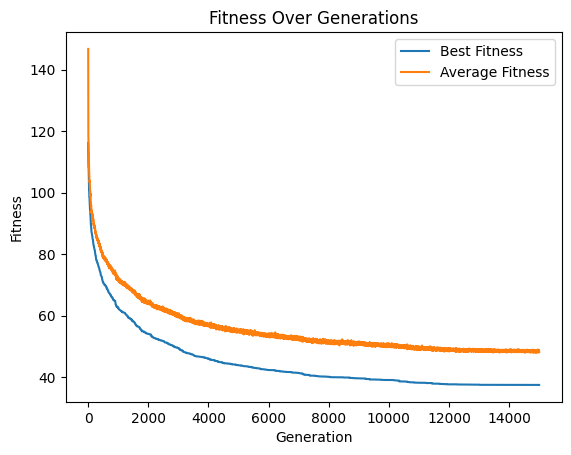


# Documentación

## Descripción de la implementación

Este proyecto implementa un algoritmo evolutivo para generar imágenes que se asemejan a una imagen objetivo utilizando una población de imágenes en escala de grises. El algoritmo se basa en principios de selección natural, donde las mejores imágenes son seleccionadas, cruzadas y mutadas a lo largo de varias generaciones para mejorar su similitud con la imagen objetivo.


### Clases y Métodos Principales

#### 1. Individual
Esta clase representa un individuo dentro de la población, que es una imagen aleatoria en escala de grises.

- **Métodos principales**:
  - create_random_image(): Genera una imagen aleatoria con rectángulos de distintos tamaños.
  - add_rectangle(): Dibuja un rectángulo aleatorio en la imagen.
  - mutate(): Introduce una mutación añadiendo nuevos rectángulos en la imagen.
  - calculate_fitness(): Calcula el fitness comparando la imagen generada con la imagen objetivo mediante la distancia euclidiana.

#### 2. Population
Esta clase representa una población de imágenes (individuos) y maneja su evolución.

- **Métodos principales**:
  - calculate_fitness(): Calcula el fitness de cada individuo y los ordena en función de su similitud con la imagen objetivo.
  - select_individual(): Selecciona un individuo de la población con mejor fitness.
  - crossover(): Realiza el cruce entre dos individuos para generar un nuevo individuo.
  - new_generation(): Crea una nueva generación de individuos mediante cruces y mutaciones, preservando los mejores individuos de la generación anterior.

#### 3. ImageProcessing
Clase encargada del procesamiento de la imagen objetivo, incluyendo su obtención y redimensionamiento.

- **Métodos principales**:
  - get_image(): Descarga la imagen desde una URL y la convierte a escala de grises.
  - resize_image(): Redimensiona la imagen objetivo al tamaño deseado.
  - scale_image(): Escala la imagen para mejorar su visualización.
  - show_image(): Muestra la imagen utilizando matplotlib.

### Funciones Auxiliares
- **plot_fitness_history()**: Grafica la evolución del fitness de la población a lo largo de las generaciones.
- **get_valid_input() y get_valid_url()**: Funciones para obtener y validar los parámetros de entrada del usuario.

## Proceso Evolutivo

El algoritmo evolutivo sigue el siguiente flujo:
1. **Inicialización**: Se crea una población de imágenes aleatorias.
2. **Cálculo de Fitness**: Cada imagen se evalúa comparándola con la imagen objetivo usando la distancia euclidiana.
3. **Selección y Cruce**: Se seleccionan los mejores individuos para cruzarlos y generar nuevos.
4. **Mutación**: Se aplica mutación a algunos individuos, añadiendo variación a la población.
5. **Nueva Generación**: Se repite el proceso para generar nuevas poblaciones durante el número de generaciones especificado.
6. **Resultado Final**: Al final, se obtiene la mejor imagen generada y se grafica la evolución del fitness.

# Pruebas

## Video de ejecución

[Video](https://estudianteccr-my.sharepoint.com/:f:/g/personal/moises_solano_estudiantec_cr/Es7Pk4syNkBDri1Hy_3X9bUBWcZMJa0AXx_q6nhYVqmR3Q?e=LgTDZB)

## Prueba 1
Descripción de la prueba: En esta prueba de usa una versión inicial del algoritmo, con la figura de triangulos y la imagen default de la planta. Se hacen alrededor de 500 generaciones.

Resultados optenidos: Se observa un fitness casi constante, no se ven mejoras en el resultado y se llega a la conclusión de que el algoritmo necesita mejoras.

## Prueba 2
Descripción de la prueba: En esta prueba de usa una versión corregida del algoritmo, cambiando la figura a rectángulos y haciendo alrededor de 10000 generaciones.

Resultados optenidos: Se observa un fitness que mejora con el paso del tiempo y una imagen que trata de asemejarse a la original.

* Generación 0

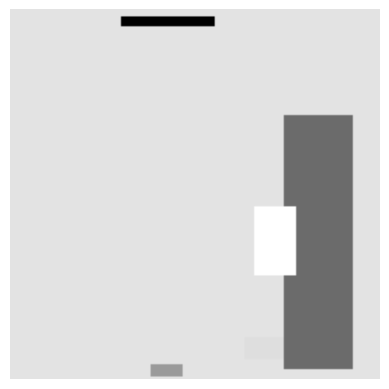

* Generación 500

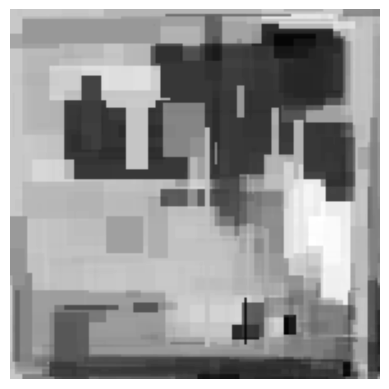

* Generación 2000

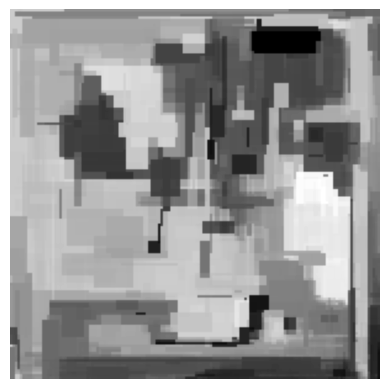

* Generación 4000

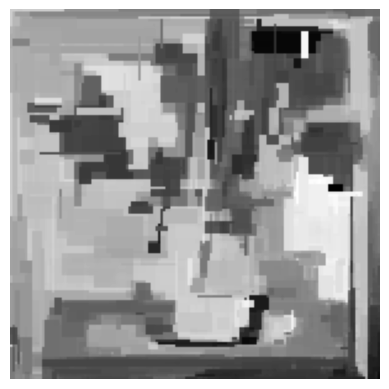

* Generación 10000

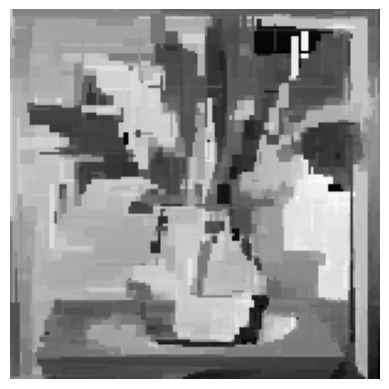

* Gráfico del fitness

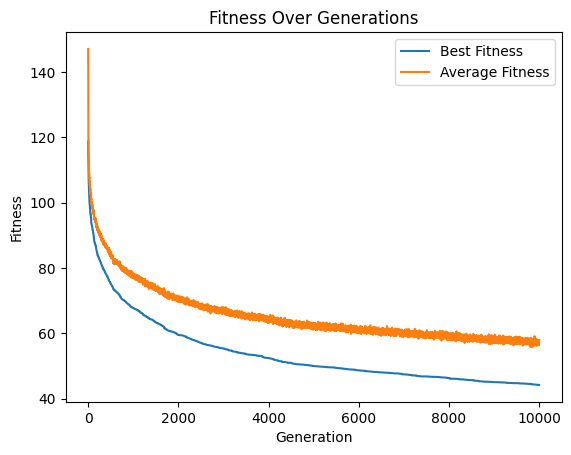



## Prueba 3
**Descripción de la prueba:** En esta prueba se hacen 100_000 generaciones para verificar si hace una diferencia importante en el resultado.

La imagen se reescala a un mayor tamaño para comprobar el algoritmo. 150x150

Las imagenes resultado están reescaladas a un x6 para que la imagen quede más grande.

**Valores utilizados:**

MUTATION_CHANCE = 0.2\
KEEP_PERCENTAGE = 0.2\
NEW_INDIVIDUALS_PERCENTAGE = 0.1\
GIF_SCALE_FACTOR = 6\
POPULATION_SIZE = 1000\
NUM_GENERATIONS = 100000\
IMAGE_SAVE_INTERVAL = 500

**Resultados optenidos:** A pesar de que el fitness siempre sigue mejorando, en las primeras 10_000 generaciones la mejora es muy alta pero conforme siguen pasando las generaciones los cambios se van minimizando. Solo se van agregando detalles a la imagen resultado.

La imagen a utilizar es la siguiente:

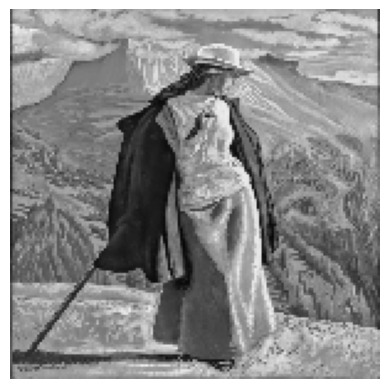


* Generación 0

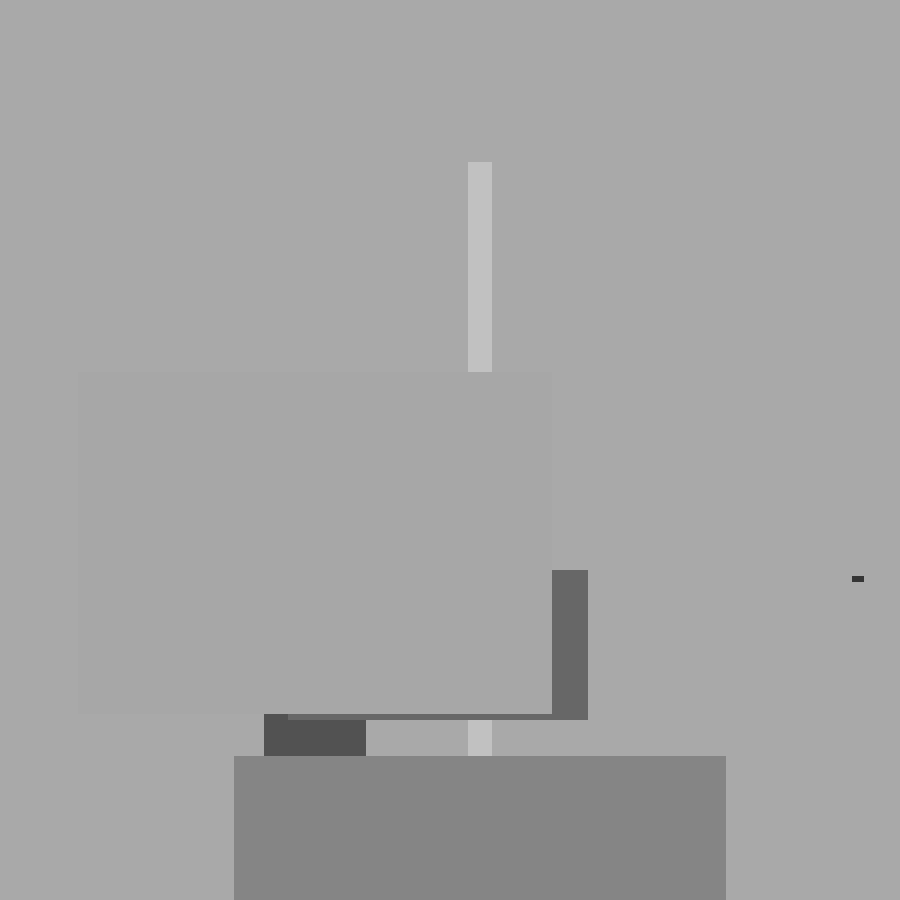

* Generación 500

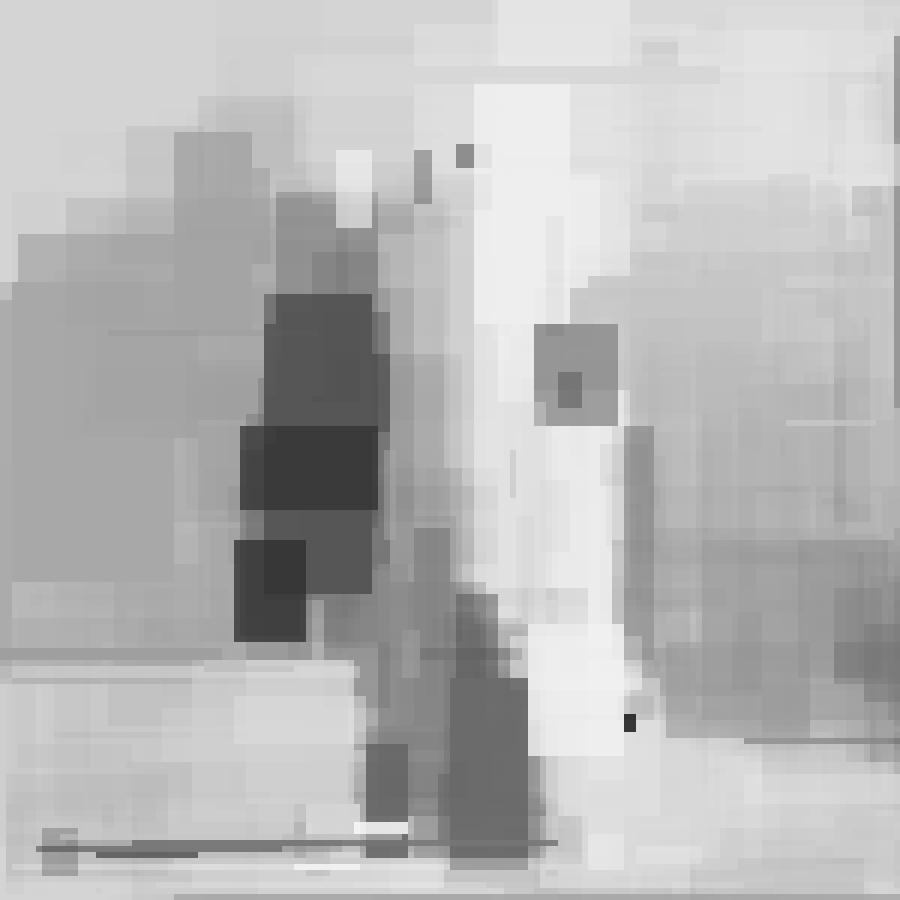

* Generación 1000

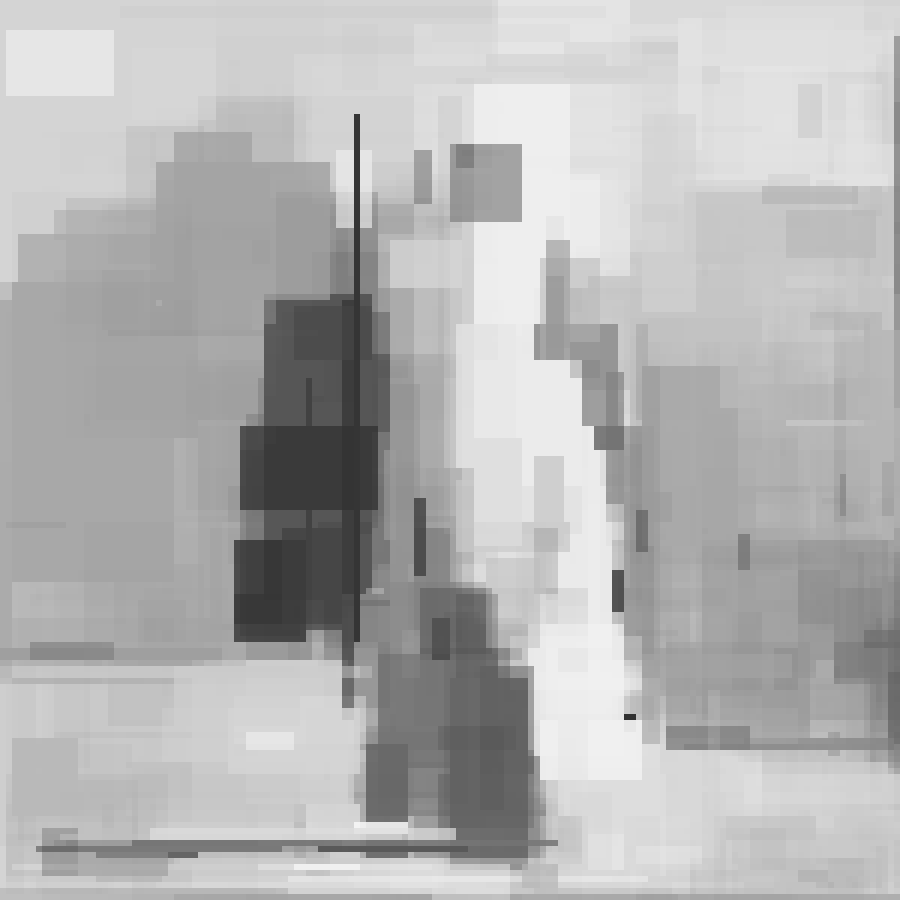

* Generacion 5000

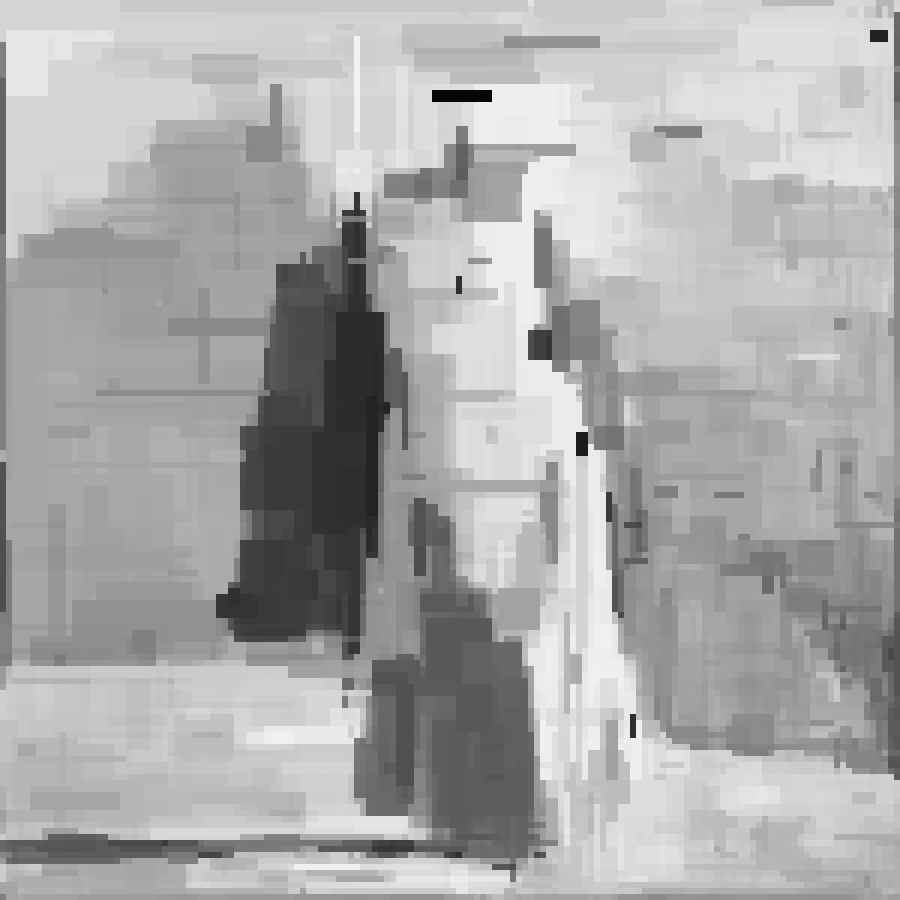

* Generación 20000

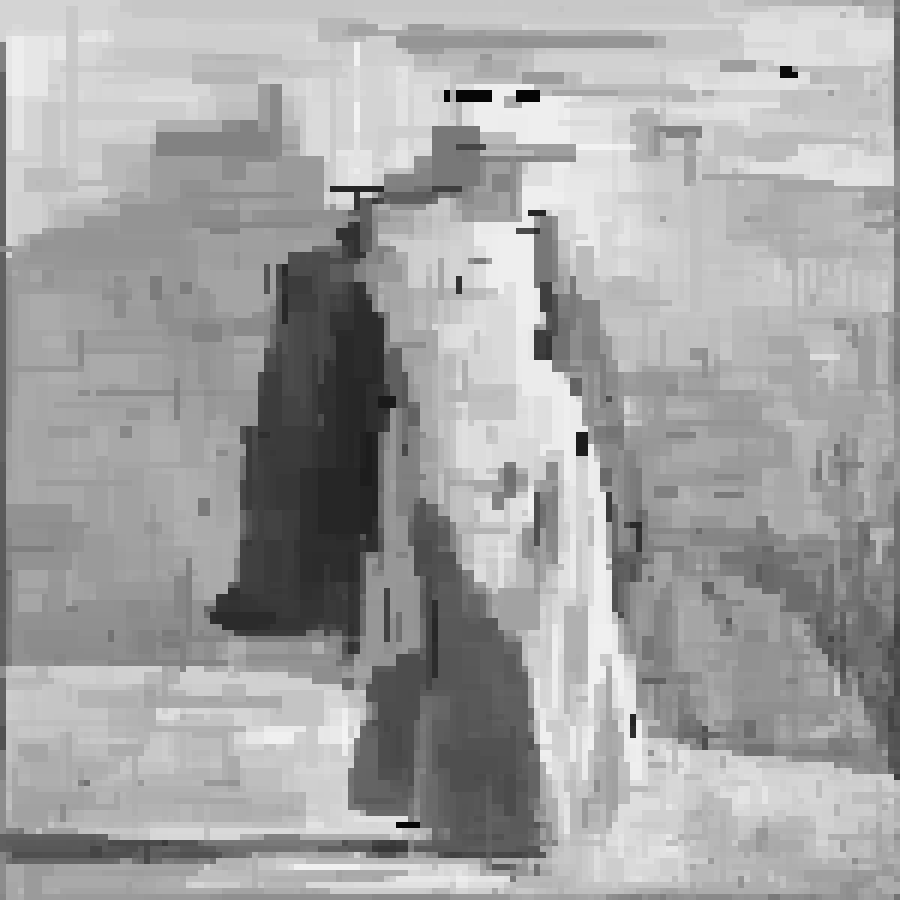

* Generación 50000

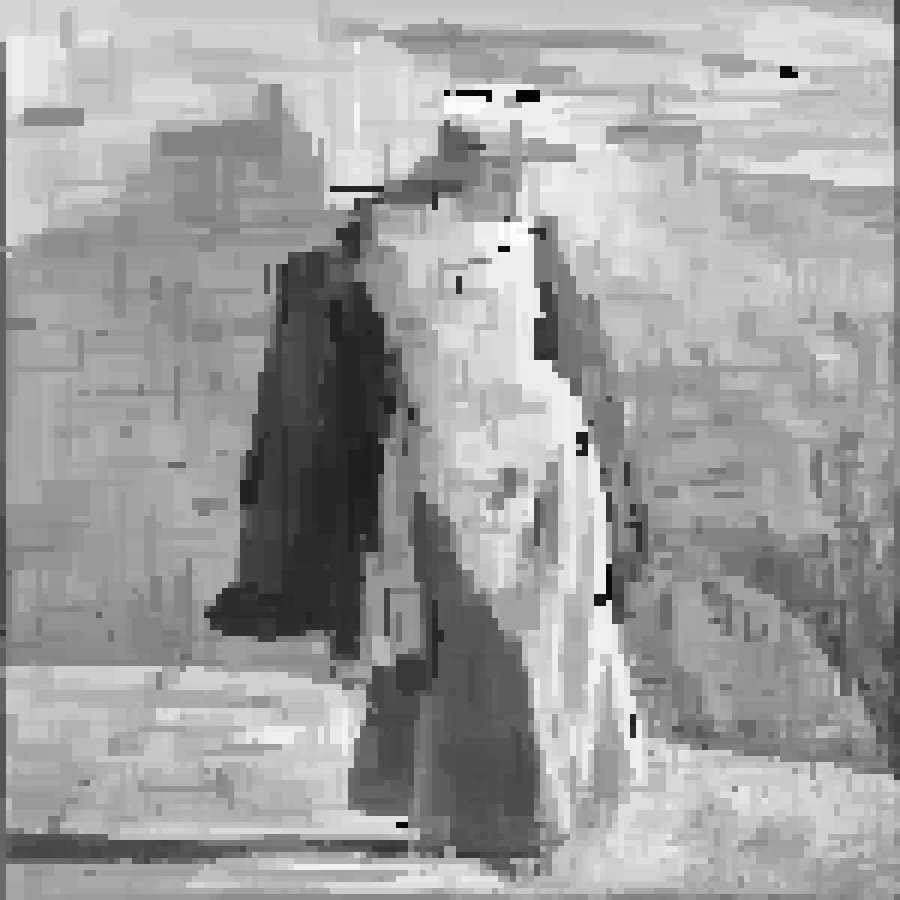

* Generación 75000

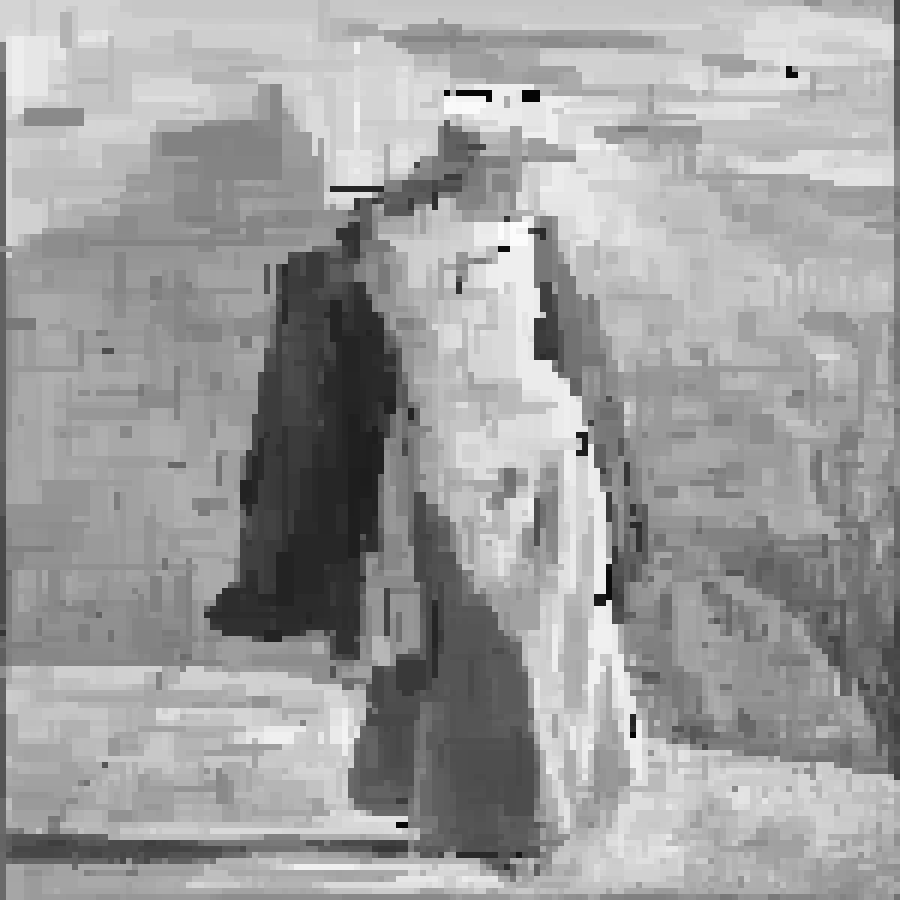

* Generacion 100000

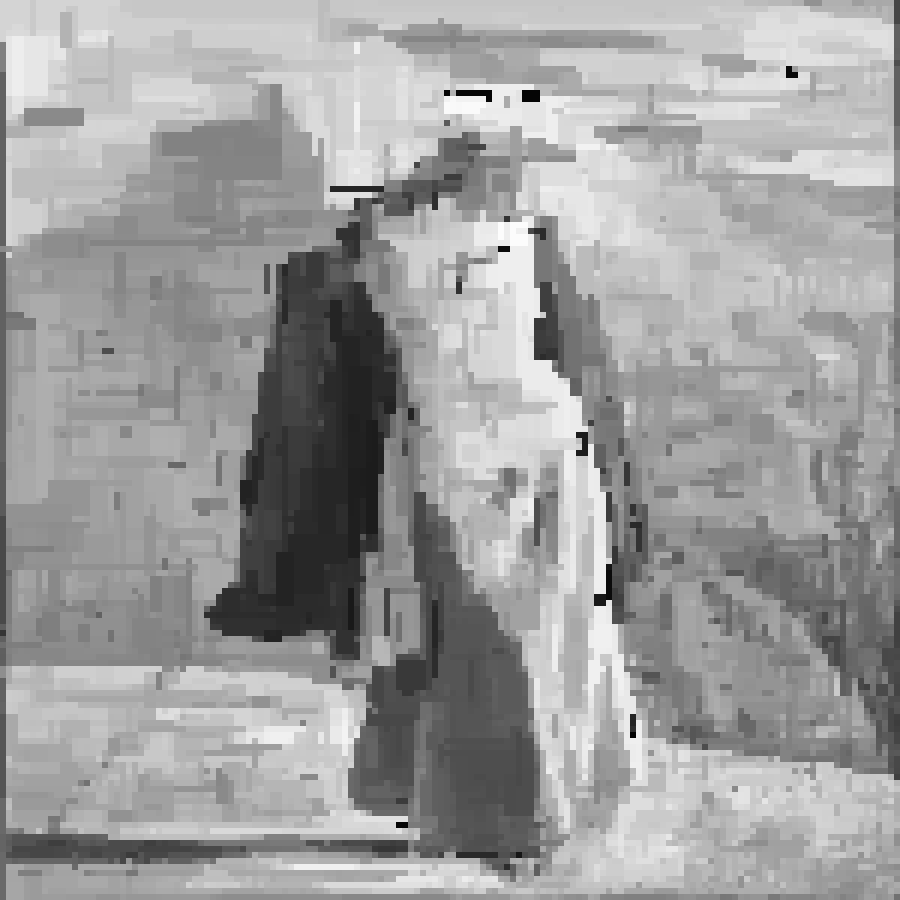

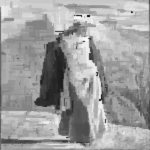

* Gráfico del Fitness

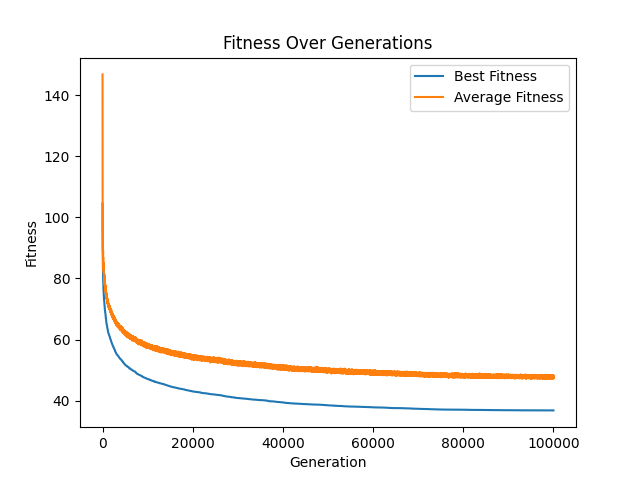

## Prueba 4
**Descripción de la prueba:** En esta prueba se hacen 100_000 generaciones para verificar si hace una diferencia importante en el resultado cambiando los valores de las constantes que afectan el algoritmo genético.

La imagen se reescala a un mayor tamaño para comprobar el algoritmo. 300x200

Las imagenes resultado están reescaladas a un x6 para que la imagen quede más grande.

**Valores utilizados:**

MUTATION_CHANCE = 0.2
KEEP_PERCENTAGE = 0.2
NEW_INDIVIDUALS_PERCENTAGE = 0.1
GIF_SCALE_FACTOR = 6
POPULATION_SIZE = 1000
NUM_GENERATIONS = 100000
IMAGE_SAVE_INTERVAL = 500

**Resultados optenidos:** A pesar de que el fitness siempre sigue mejorando, en las primeras 10_000 generaciones la mejora es muy alta pero conforme siguen pasando las generaciones los cambios se van minimizando. Solo se van agregando detalles a la imagen resultado.

La imagen a utilizar es la siguiente:

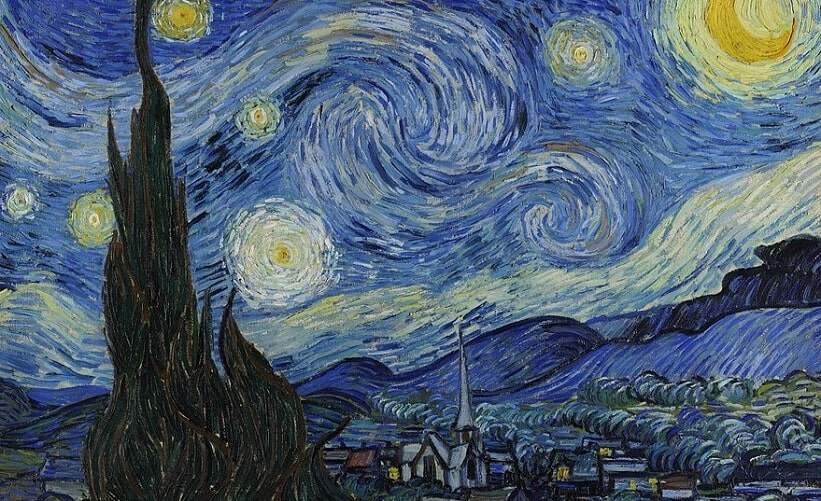

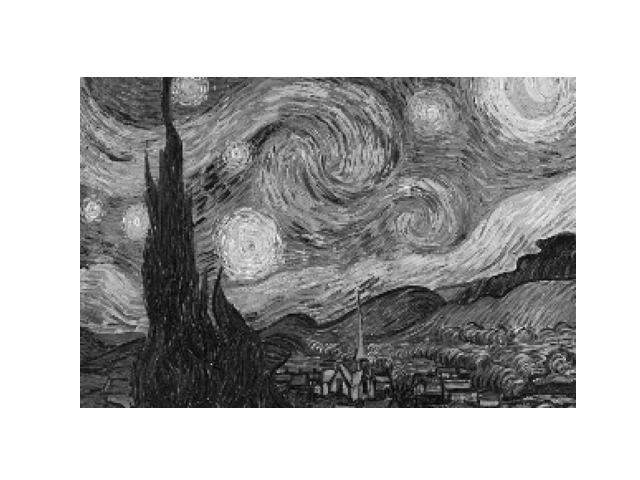

* Generación 0

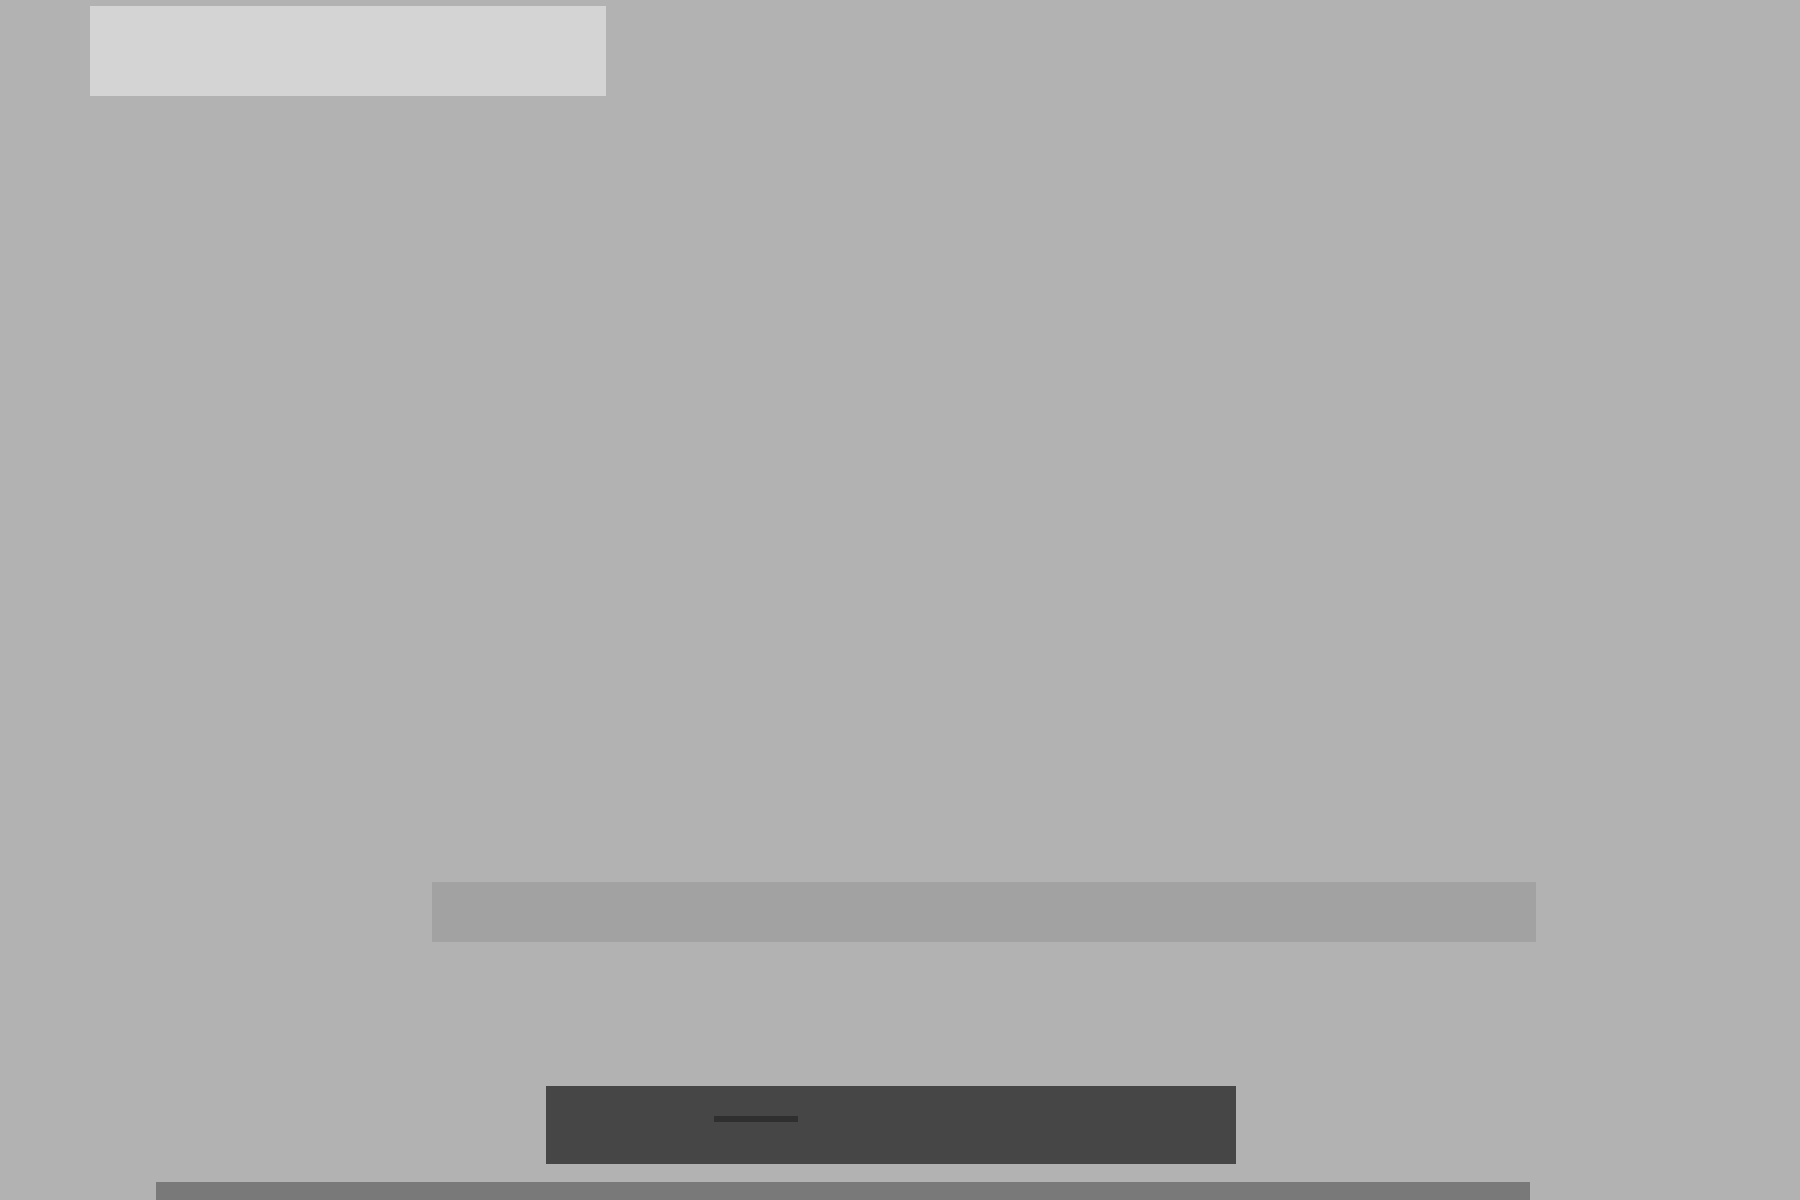

* Generación 500

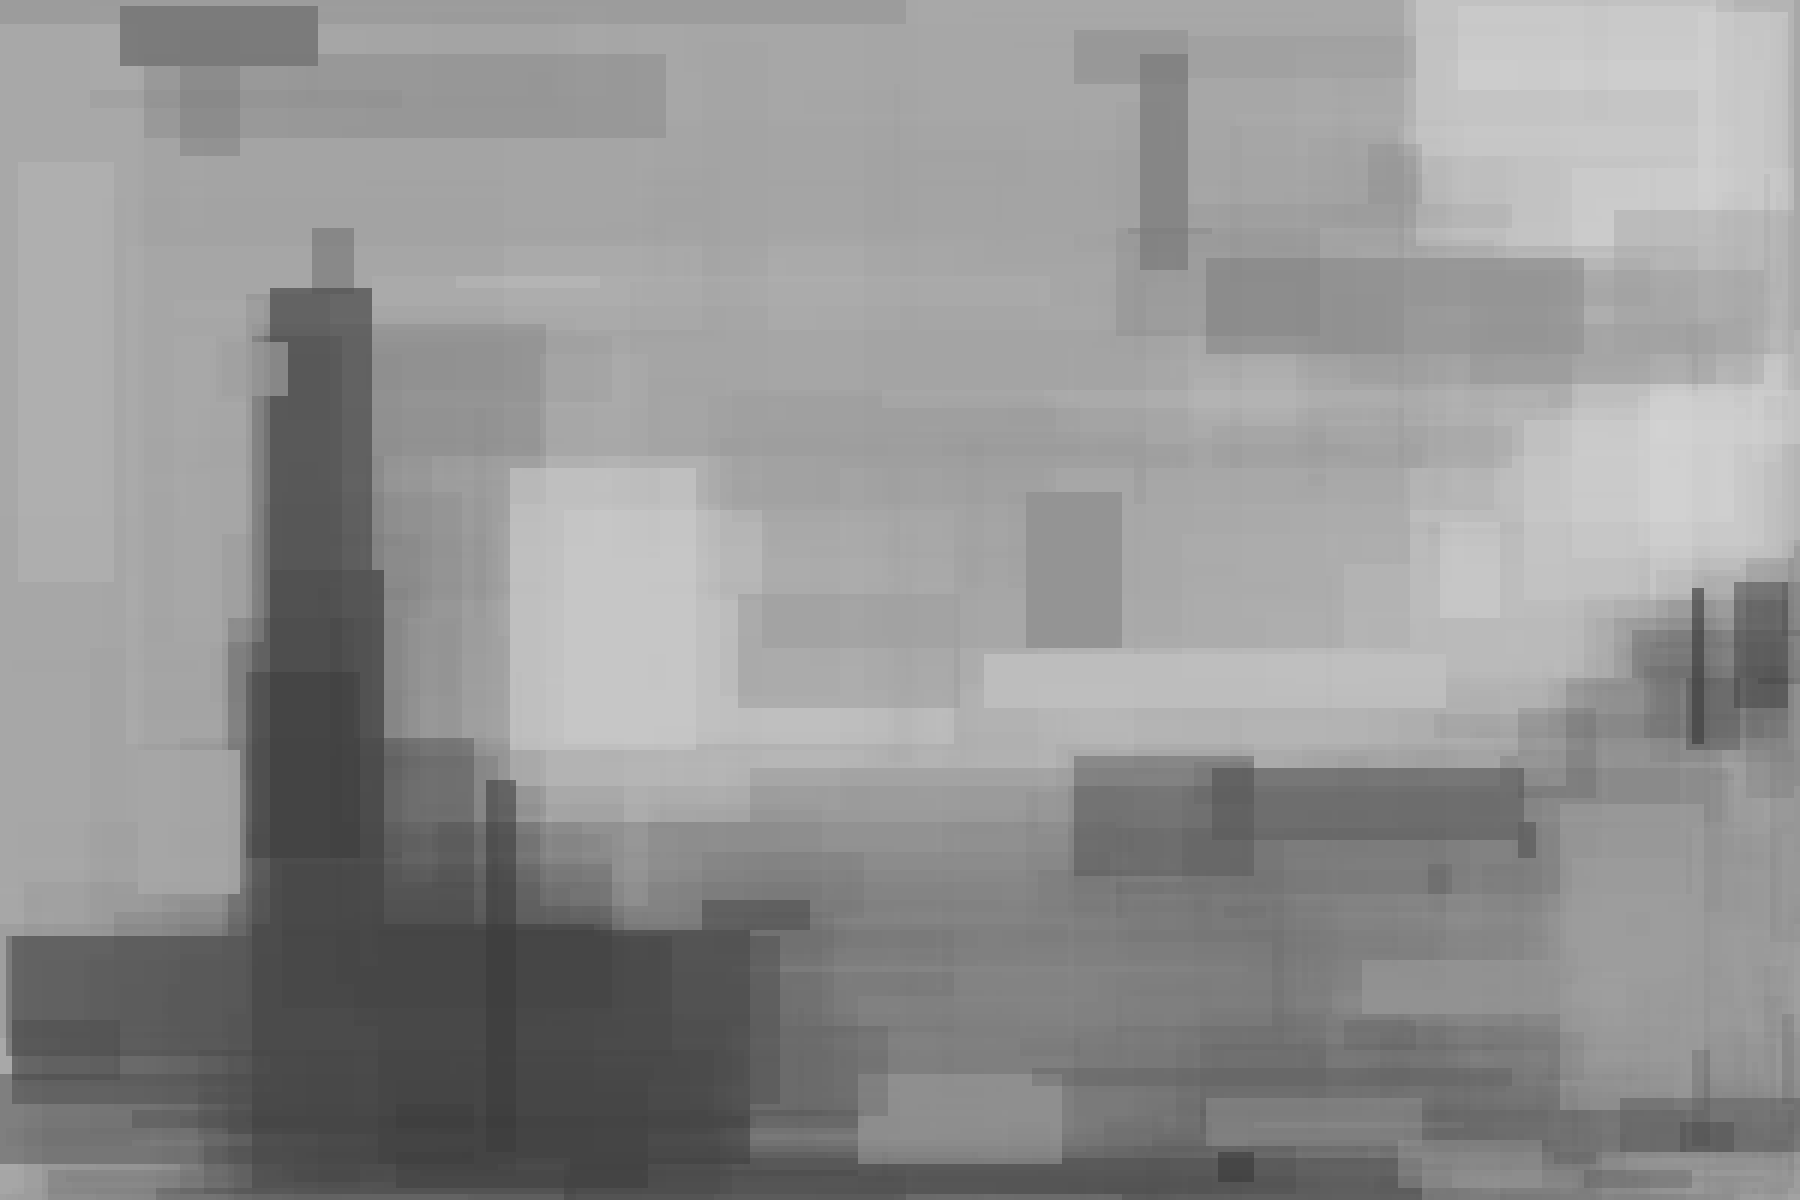

* Generación 5000

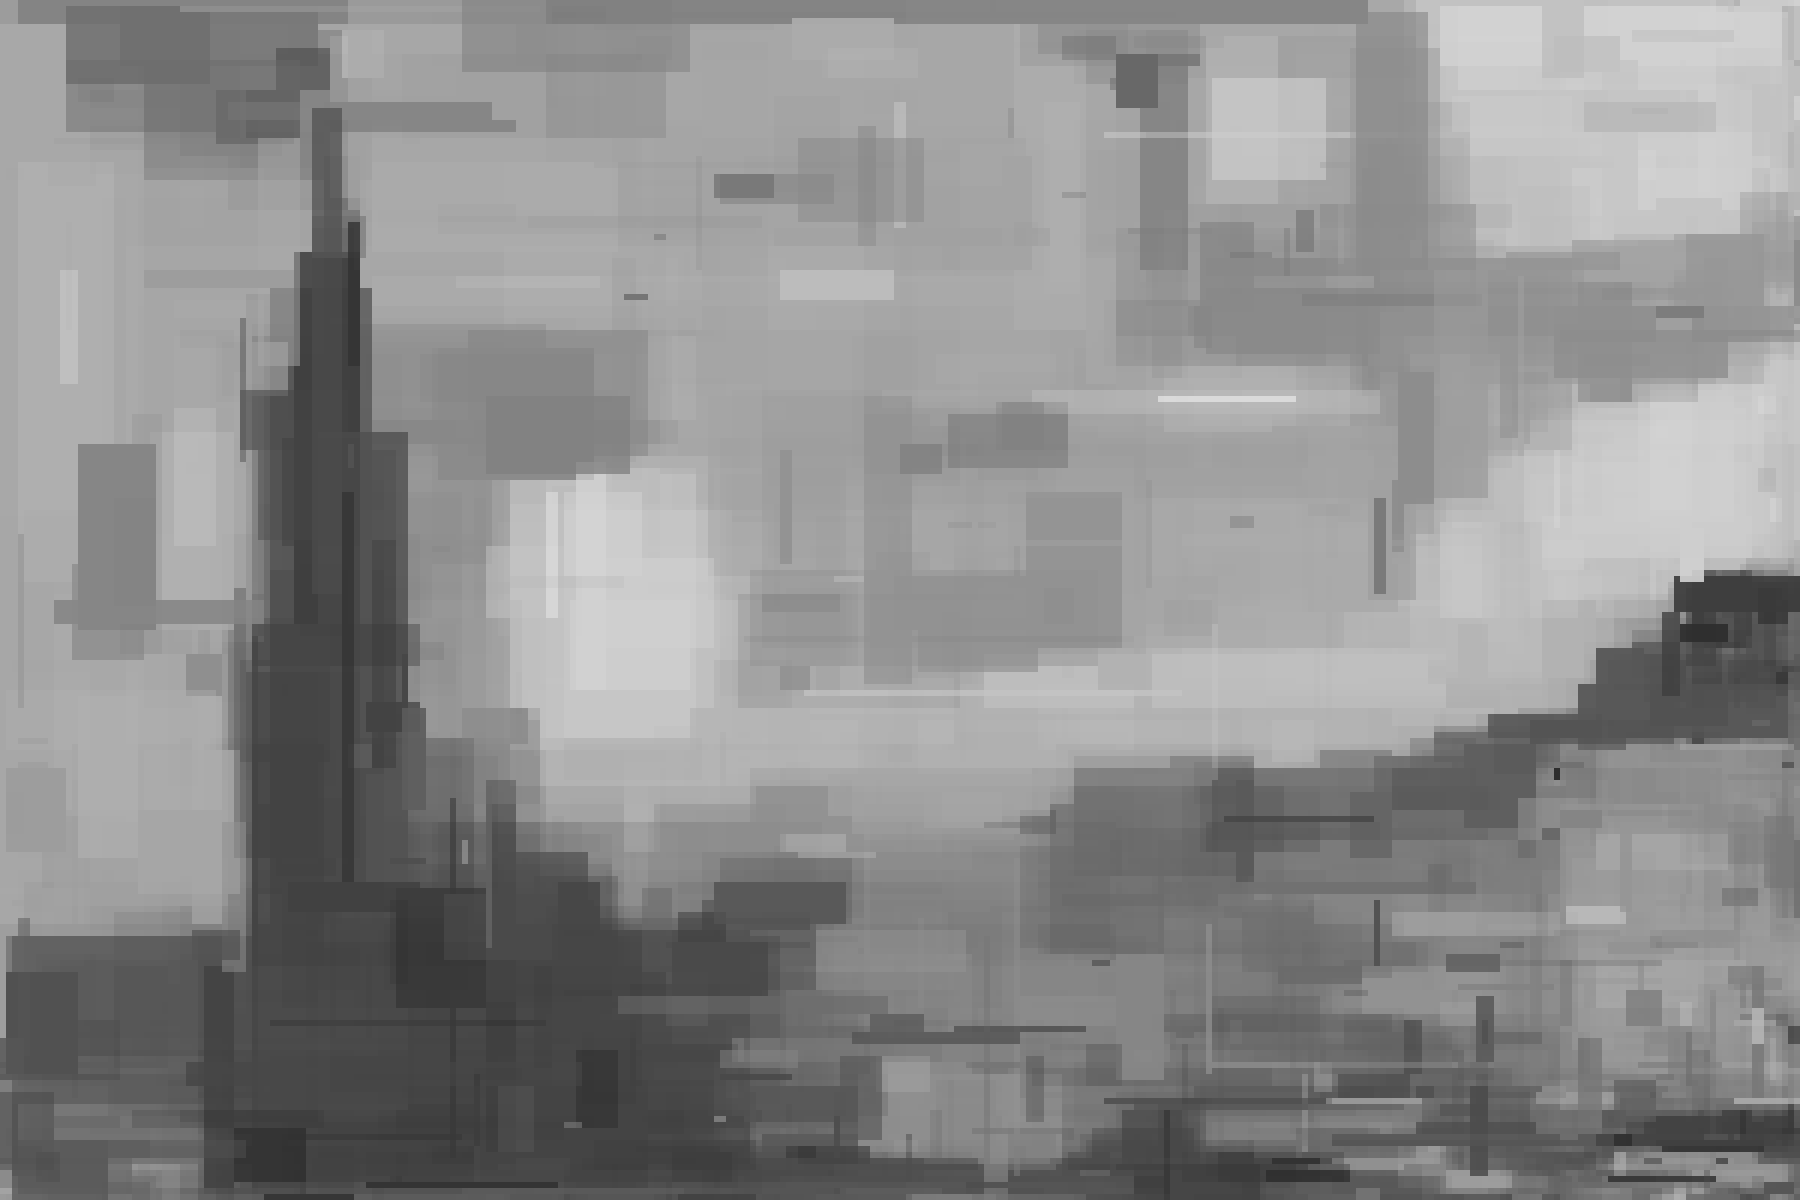

* Generación 10000

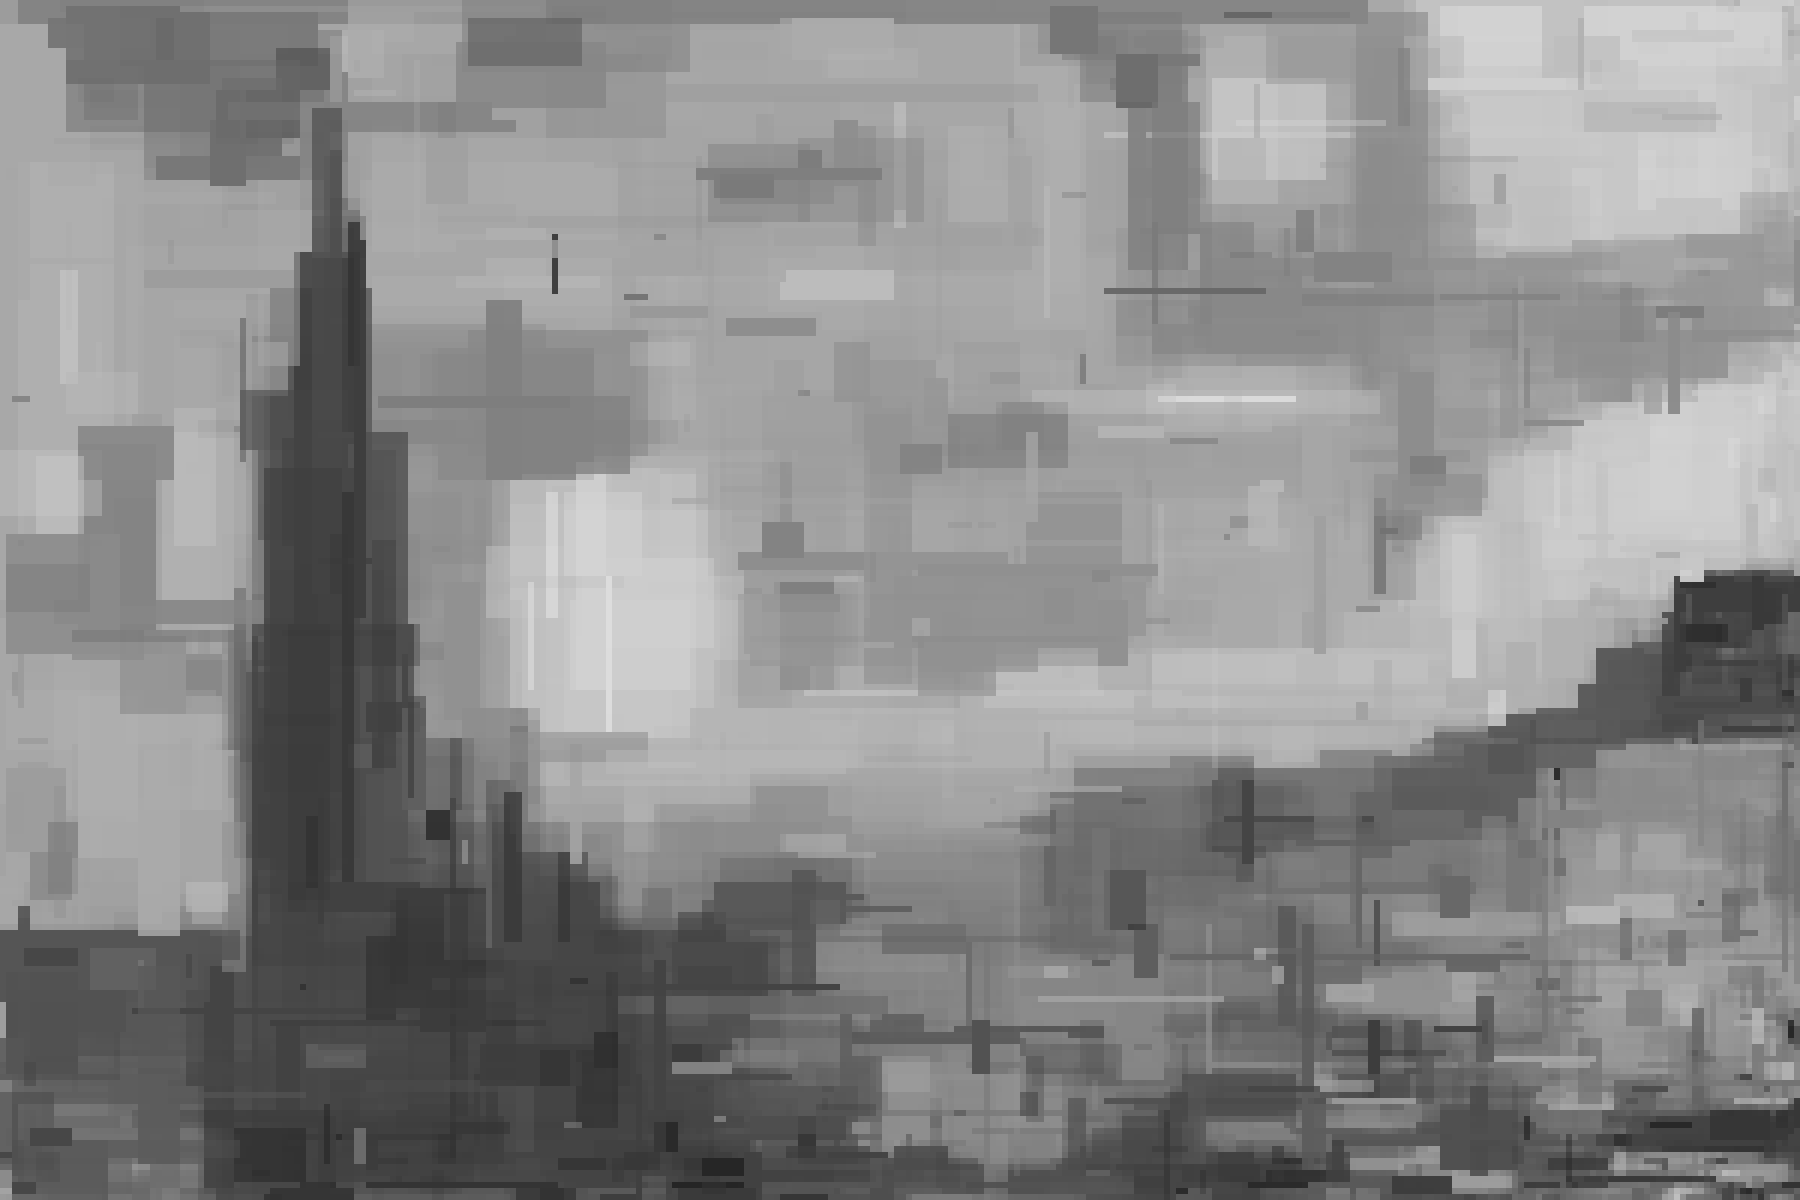

* Generación 50 000

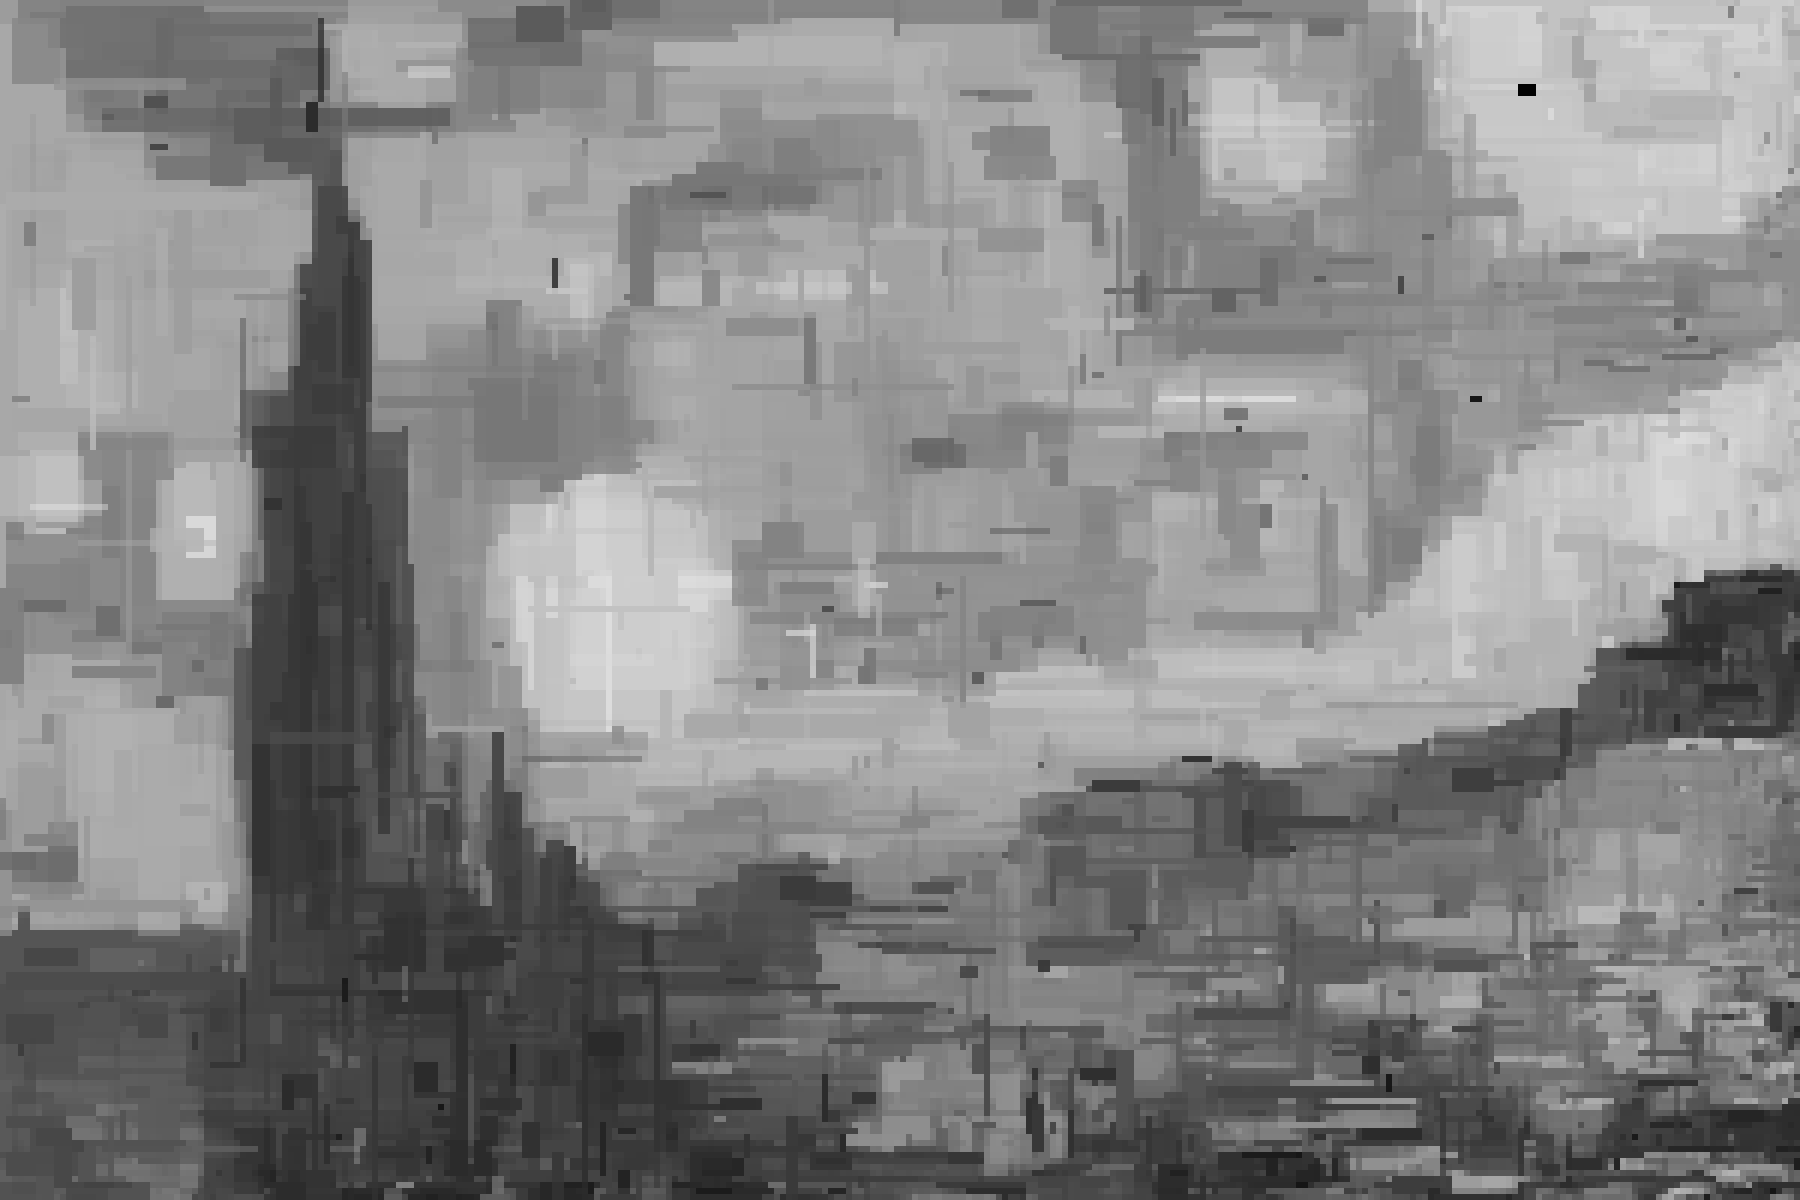

* Generación 100000

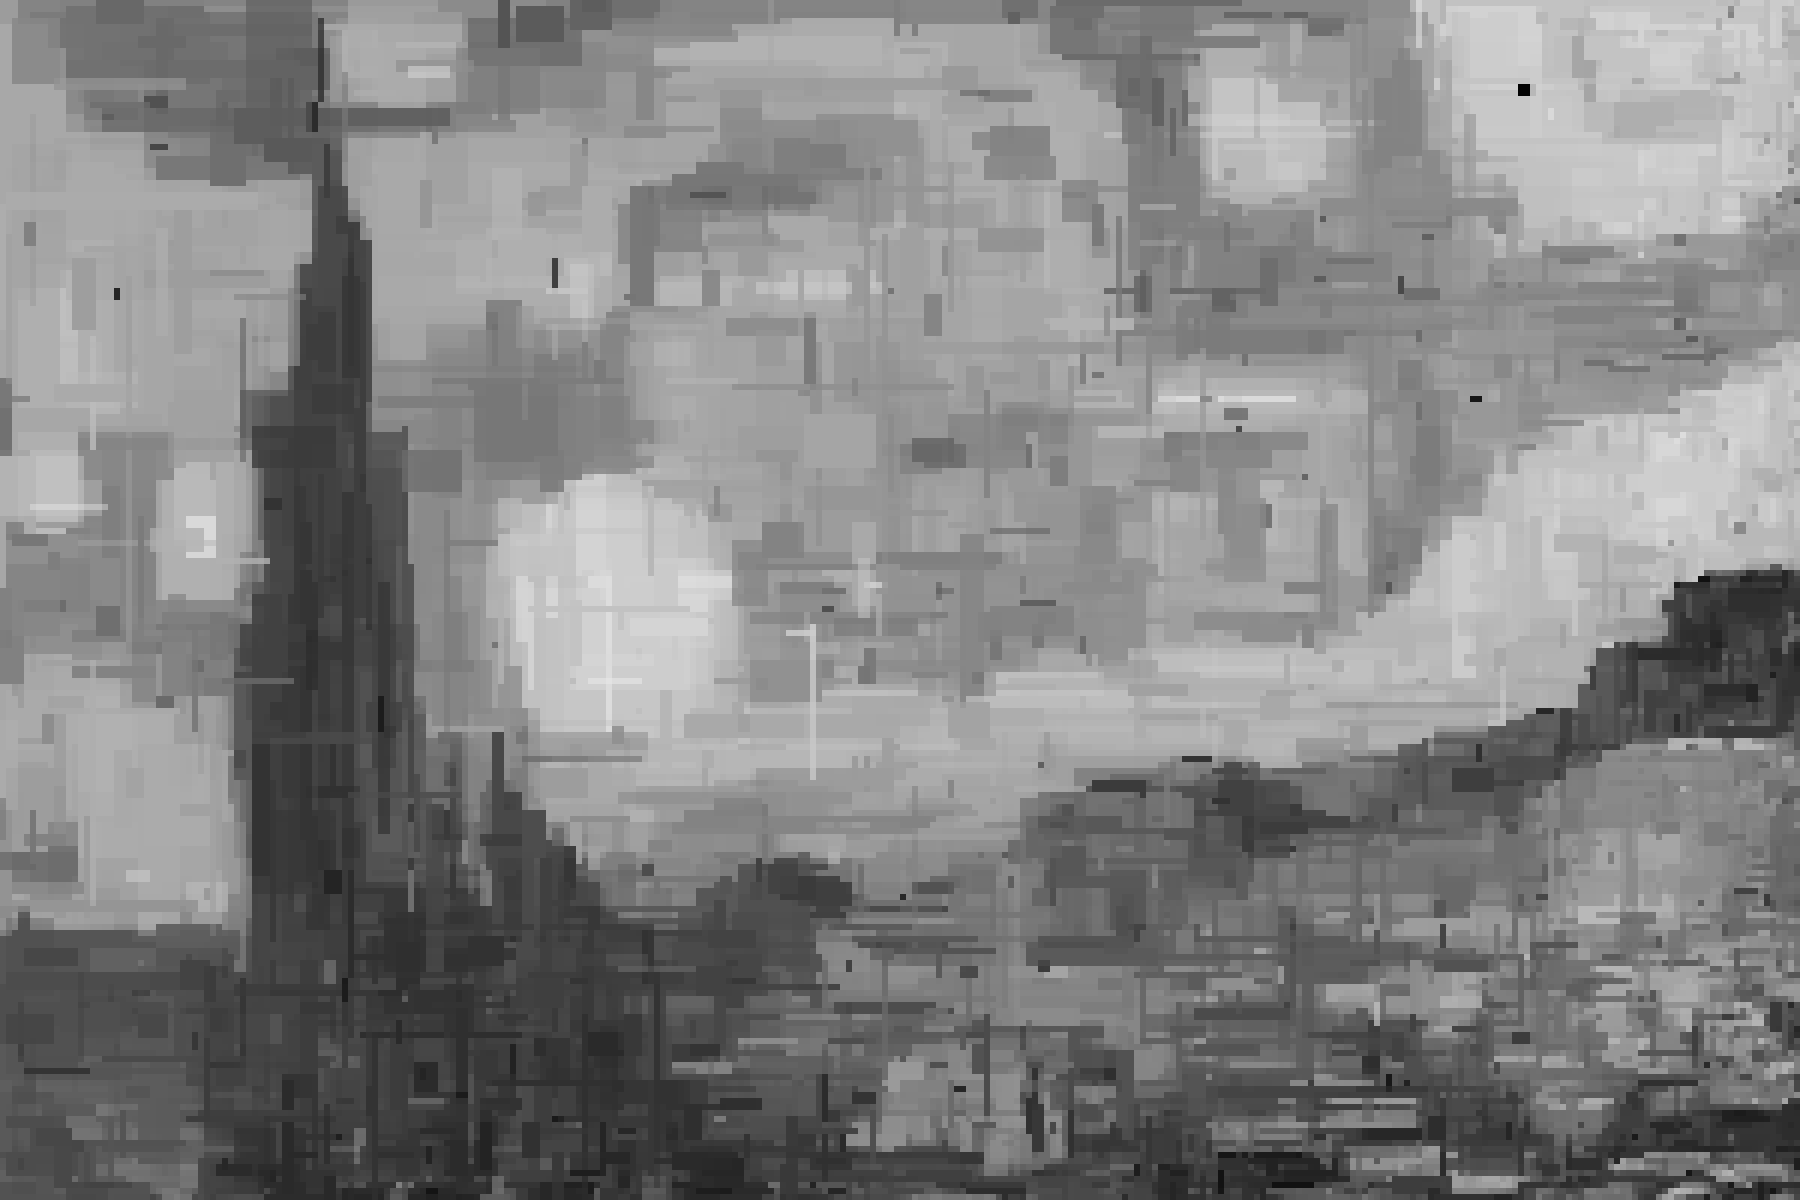

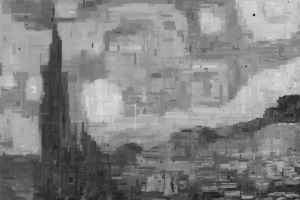

* Gráfico del Fitness

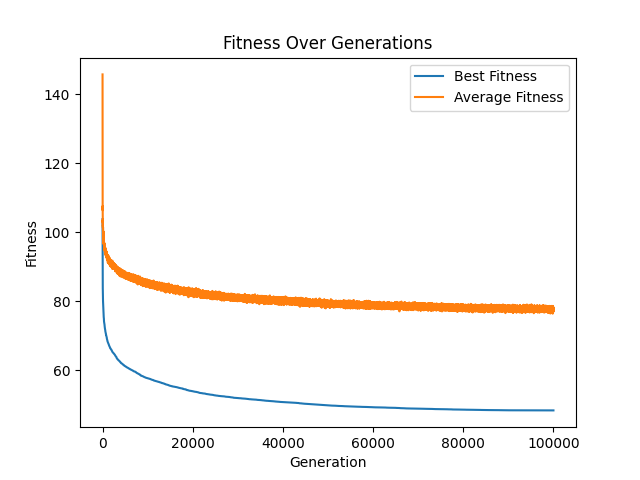

## Prueba 5
**Descripción de la prueba:** En esta prueba se utiliza la recomendación del profesor de utilizar una imagen de tamaño 50x50. Además, es en la prueba que se utilizan más individuos por población para comprobar si hay un cambio notorio.

**Valores utilizados:**

MUTATION_CHANCE = 0.4
KEEP_PERCENTAGE = 0.4
NEW_INDIVIDUALS_PERCENTAGE = 0.3
GIF_SCALE_FACTOR = 6
POPULATION_SIZE = 10000
NUM_GENERATIONS = 10000
IMAGE_SAVE_INTERVAL = 500

**Resultados optenidos:** En esta prueba el fitness mejora más y se acerca más a cero indicando un mejor rendimiento. Es en la prueba que el fitness es más bajo a pesar de tener pocas generaciones.

La imagen a utilizar es la siguiente:

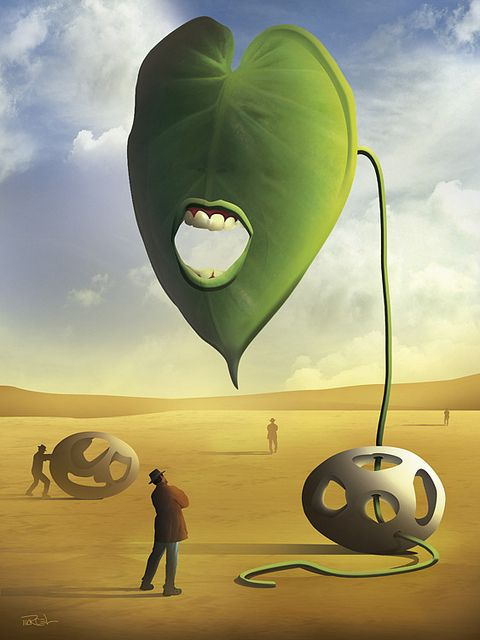

* Generación 0

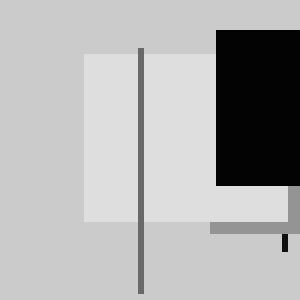

* Generación 500

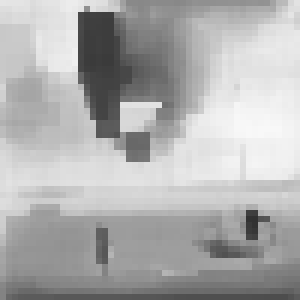

* Generación 1000

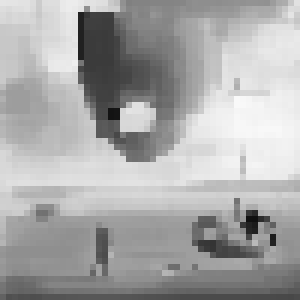

* Generación 5000

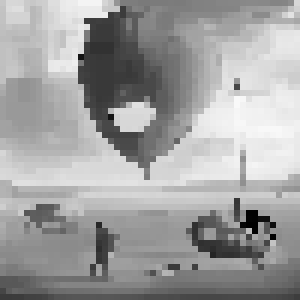

* Generación 10000

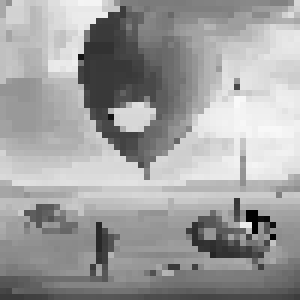

* Gráfico del fitness

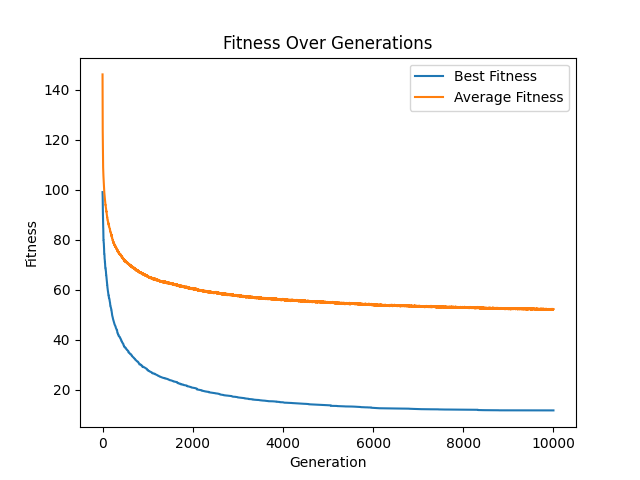